In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from tqdm.notebook import tqdm
from IPython.display import Audio

In [ ]:
SR = 44100
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 40
WINDOW_SIZE = 1 # seconds
DATA_DIR = 'data'

def split_audio(audio_path) -> list:
    # Load audio
    y, sr = librosa.load(audio_path, sr=SR)

    # Ensure the audio is mono
    if len(y.shape) > 1:
        y = librosa.to_mono(y)

    # Split audio into fixed-size windows
    windows = []
    window_length = int(WINDOW_SIZE * SR)
    for i in range(0, len(y), window_length):
        window = y[i:i + window_length]
        # Pad the last window if it's shorter than WINDOW_SIZE
        if len(window) < window_length:
            window = np.pad(window, (0, window_length - len(window)), mode='constant')
        windows.append(window)
    return windows

def split_audio_sliding_window(audio_path, stride_ms=500):
    """
    Splits audio into sliding windows with a specified stride in milliseconds,
    with zero-padding if the last window is smaller than the window size.
    """
    # Load audio
    y, sr = librosa.load(audio_path, sr=SR)

    # Ensure the audio is mono
    if len(y.shape) > 1:
        y = librosa.to_mono(y)

    # Convert stride from ms to samples
    stride_samples = int(stride_ms / 1000 * SR)

    # Split audio into sliding windows
    windows = []
    window_length = int(WINDOW_SIZE * SR)  # 1-second window in samples
    for i in range(0, len(y) - window_length + 1, stride_samples):
        window = y[i:i + window_length]
        windows.append(window)

    # Handle the last window if not fully covered
    if len(y) % stride_samples != 0:
        last_window = y[-window_length:]
        # Pad with zeros if the last window is shorter than the window length
        if len(last_window) < window_length:
            last_window = np.pad(last_window, (0, window_length - len(last_window)), mode='constant')
        windows.append(last_window)

    return windows

def extract_mfcc(window):
    # Compute MFCC
    mfcc = librosa.feature.mfcc(y=window, sr=SR, n_mfcc=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
    return mfcc

def get_the_ith_file(path, i):
    return os.path.join(path, os.listdir(path)[i])

def plot_mfcc(path):
    windows = split_audio(path)
    for i, window in enumerate(windows):
        mfcc = extract_mfcc(window)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc, x_axis='time')
        plt.colorbar()
        plt.title(f'MFCC {i}')
        plt.tight_layout()
        plt.show()

In [3]:
# Variables to store data
mfccs = []
labels = []
gl_coughs_count = 0
gl_non_coughs_count = 0

In [ ]:
# Limiters
N_COUGHS = -1           # Number of coughs to extract from each audio file. Set to -1 to extract all coughs.
N_NON_COUGHS = 1200     # Number of non-coughs to extract from each audio file. Set to -1 to extract all non-coughs.
first_dataset_cough_count = 0
first_dataset_non_cough_count = 0

# Load the first data set (https://www.kaggle.com/datasets/himanshu007121/cough-audio-dataset)
cough_dir = os.path.join(DATA_DIR, 'coughs')
non_cough_dir = os.path.join(DATA_DIR, 'not_coughs')

# Load coughs
cough_files = os.listdir(cough_dir)

for cough_file in tqdm(cough_files, desc='Loading coughs'):
    # Check if we have reached the desired number of coughs
    if first_dataset_cough_count == N_COUGHS and N_COUGHS != -1:
        print("Coughs count reached")
        break

    # Load the audio file
    cough_path = os.path.join(cough_dir, cough_file)
    windows = split_audio(cough_path)
    for window in windows:
        mfcc = extract_mfcc(window)
        mfccs.append(mfcc)
        labels.append(1)
    gl_coughs_count += 1
    first_dataset_cough_count += 1

# Load non-coughs
non_cough_files = os.listdir(non_cough_dir)

for non_cough_file in tqdm(non_cough_files, desc='Loading non-coughs'):
    # Check if we have reached the desired number of non-coughs
    if first_dataset_non_cough_count == N_NON_COUGHS and N_NON_COUGHS != -1:
        print("Non coughs count reached")
        break
    
    # Load the audio file
    non_cough_path = os.path.join(non_cough_dir, non_cough_file)
    windows = split_audio(non_cough_path)
    for window in windows:
        mfcc = extract_mfcc(window)
        mfccs.append(mfcc)
        labels.append(0)
    gl_non_coughs_count += 1
    first_dataset_non_cough_count += 1

# Make sure all MFCCs have the same shape
for mfcc in mfccs:
    assert mfcc.shape == mfccs[0].shape, 'All MFCCs should have the same shape'

Loading coughs:   0%|          | 0/431 [00:00<?, ?it/s]

Loading non-coughs:   0%|          | 0/12813 [00:00<?, ?it/s]

Non coughs count reached


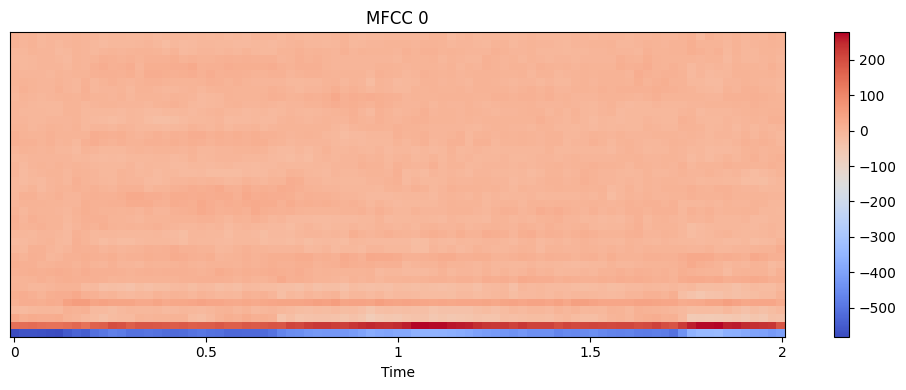

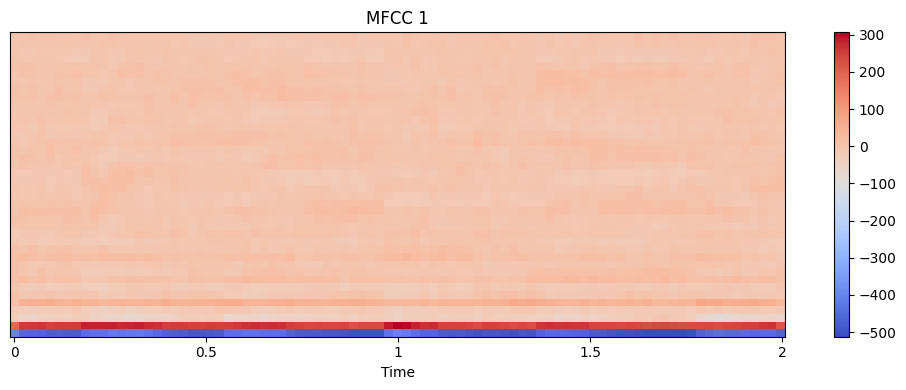

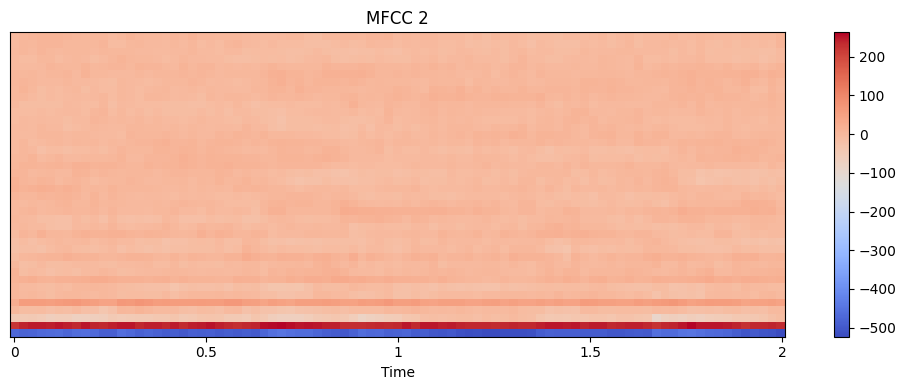

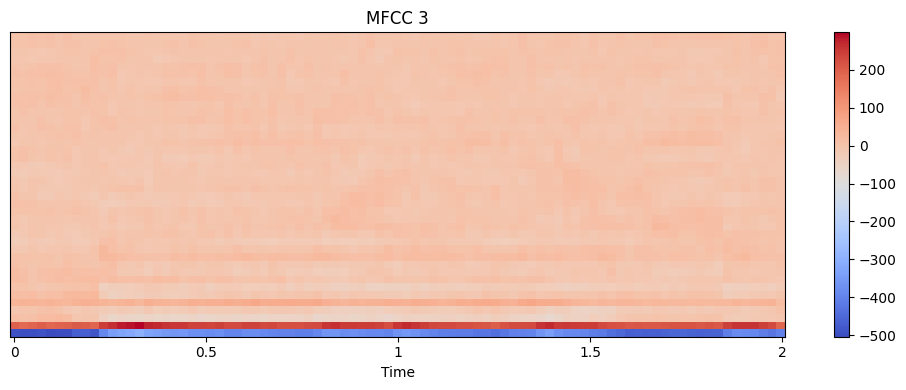

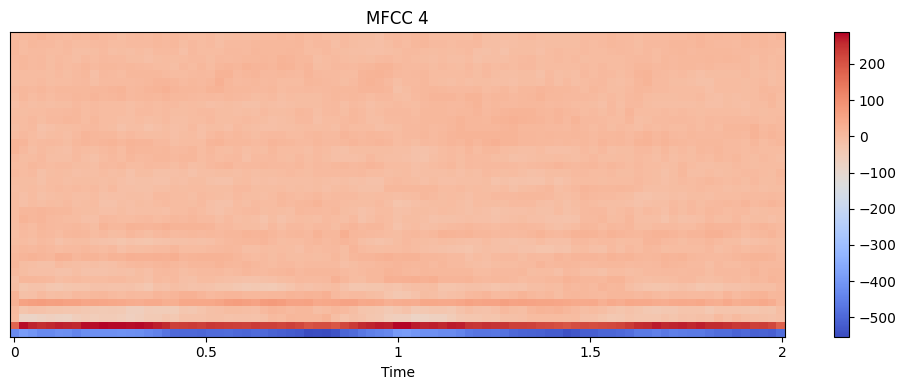

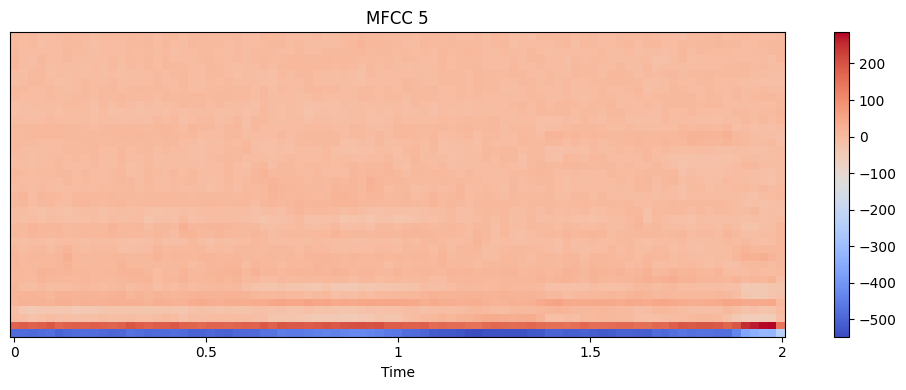

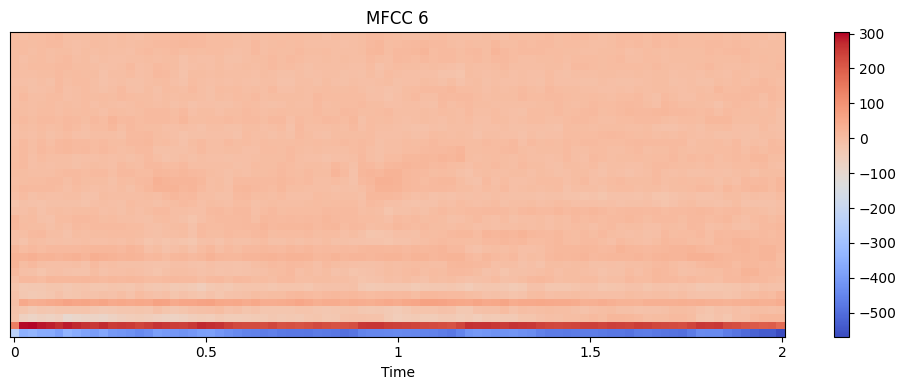

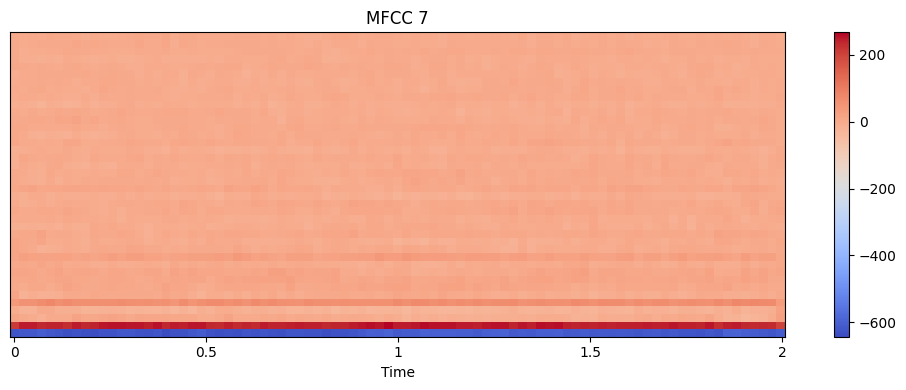

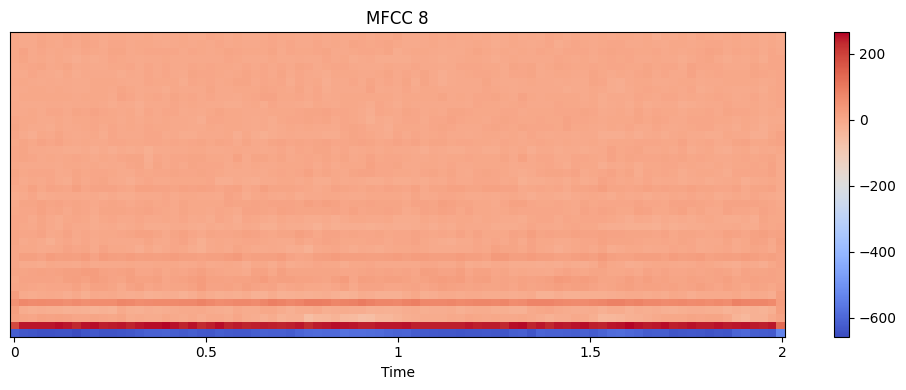

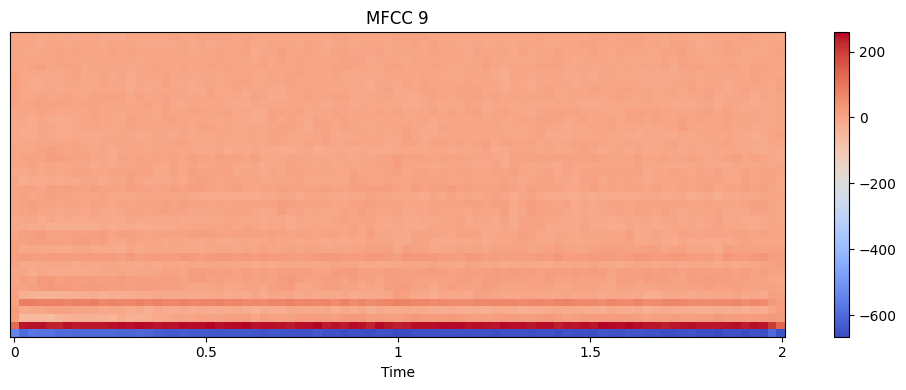

In [5]:
# Visualize some data
plot_mfcc(get_the_ith_file(cough_dir, 5))

In [ ]:
# Constants
N_COUGHS_COUGHVID = 4500          # Number of coughs to extract from each audio file. Set to -1 to extract all coughs.
N_NON_COUGHS_COUGHVID = 2800      # Number of non-coughs to extract from each audio file. Set to -1 to extract all non-coughs.
coughvid_coughs_count = 0
coughvid_non_coughs_count = 0

# Confidence Threshold
THRESHOLD = 0.1

# Skip Flags
skip_coughs = False
skip_non_coughs = False

# Load Dataset from COUGHVID-19 dataset (https://www.kaggle.com/datasets/nasrulhakim86/coughvid-wav)
COUGHVID_DIR = os.path.join(DATA_DIR, 'coughvid')

wav_files = [file for file in os.listdir(COUGHVID_DIR) if file.endswith('.wav')]
json_files = [file for file in os.listdir(COUGHVID_DIR) if file.endswith('.json')]

for wav_file in tqdm(wav_files, desc='Loading COUGHVID dataset'):
    if skip_coughs and skip_non_coughs:
        break

    # Find the corresponding JSON file
    json_file = wav_file.replace('.wav', '.json')
    json_path = os.path.join(COUGHVID_DIR, json_file)

    # Check if the JSON file exists
    if not os.path.exists(json_path):
        # Skip the file if no JSON file is found
        print(f'No JSON file found for {wav_file}, skipping...')
        continue

    # Load JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
        confidence = float(data['cough_detected'])

    # Check if it's a cough or not
    if confidence > 1-THRESHOLD:        # if confidence = 0.1, then confidence > 0.9
        if skip_coughs:
            continue

        # Check if limit is reached
        if coughvid_coughs_count == N_COUGHS_COUGHVID and N_COUGHS_COUGHVID != -1:
            print("Coughs count reached")
            skip_coughs = True
            continue

        # Preprocess the audio
        windows = split_audio(os.path.join(COUGHVID_DIR, wav_file))
        for window in windows:
            mfcc = extract_mfcc(window)
            mfccs.append(mfcc)
            labels.append(1)
        gl_coughs_count += 1
        coughvid_coughs_count += 1

    elif confidence < THRESHOLD:    # if confidence = 0.1, then confidence < 0.1
        if skip_non_coughs:
            continue

        # Check if limit is reached
        if coughvid_non_coughs_count == N_NON_COUGHS_COUGHVID and N_NON_COUGHS_COUGHVID != -1:
            print("Non coughs count reached")
            skip_non_coughs = True
            continue

        # Preprocess the audio
        windows = split_audio(os.path.join(COUGHVID_DIR, wav_file))
        for window in windows:
            mfcc = extract_mfcc(window)
            mfccs.append(mfcc)
            labels.append(0)
        gl_non_coughs_count += 1
        coughvid_non_coughs_count += 1

Loading COUGHVID dataset:   0%|          | 0/27550 [00:00<?, ?it/s]

Coughs count reached
Non coughs count reached


In [7]:
# Print the number of coughs and non-coughs
print(f'Number of coughs: {gl_coughs_count}')
print(f'Number of non-coughs: {gl_non_coughs_count}')

Number of coughs: 4931
Number of non-coughs: 4000


In [8]:
from sklearn.preprocessing import StandardScaler

# Scale the data
mfccs_np = np.array(mfccs)

# Flatten the data and scale it
n_samples, n_mfccs, n_frames = mfccs_np.shape
mfccs_flat = mfccs_np.reshape(n_samples, -1)
scaler = StandardScaler()
mfccs_scaled_flat = scaler.fit_transform(mfccs_flat)

# Reshape the data
mfccs_scaled_standard = mfccs_scaled_flat.reshape(n_samples, n_mfccs, n_frames)


In [9]:
# Split the Data
from sklearn.model_selection import train_test_split

# Split data to training and testing
X_train, X_test, y_train, y_test = train_test_split(mfccs_scaled_standard, labels, test_size=0.2, random_state=42)

# Further split the training data to training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print out the shapes
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')
print(f'Validation data shape: {X_val.shape}')


Training data shape: (44873, 40, 87)
Testing data shape: (14024, 40, 87)
Validation data shape: (11219, 40, 87)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build the model
def create_model(input_shape):
    model = models.Sequential()
    
    # Input Layer
    model.add(layers.InputLayer(input_shape=input_shape))
    
    # Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Second Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flattening Layer
    model.add(layers.Flatten())
    
    # Fully Connected Layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    
    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Create the model
model = create_model(input_shape=(N_MELS, X_train.shape[2], 1))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


C:\Users\Enrique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\Enrique\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 87, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13440)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,739,393 (6.64 MB)

 Trainable params: 1,739,393 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Prepare the data
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

In [12]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6850 - loss: 0.5925 - val_accuracy: 0.7452 - val_loss: 0.5088
Epoch 2/50
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7404 - loss: 0.5003 - val_accuracy: 0.7545 - val_loss: 0.4687
Epoch 3/50
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7586 - loss: 0.4655 - val_accuracy: 0.7592 - val_loss: 0.4594
Epoch 4/50
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7752 - loss: 0.4394 - val_accuracy: 0.7592 - val_loss: 0.4625
Epoch 5/50
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7915 - loss: 0.4134 - val_accuracy: 0.7650 - val_loss: 0.4586
Epoch 6/50
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8037 - loss: 0.3881 - val_accuracy: 0.7647 - val_loss: 0.4761
Epoch 7/50
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8183 - loss: 0.3609 - val_accuracy: 0.7650 - val_loss: 0.4821
Epoch 8/50
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8390 -

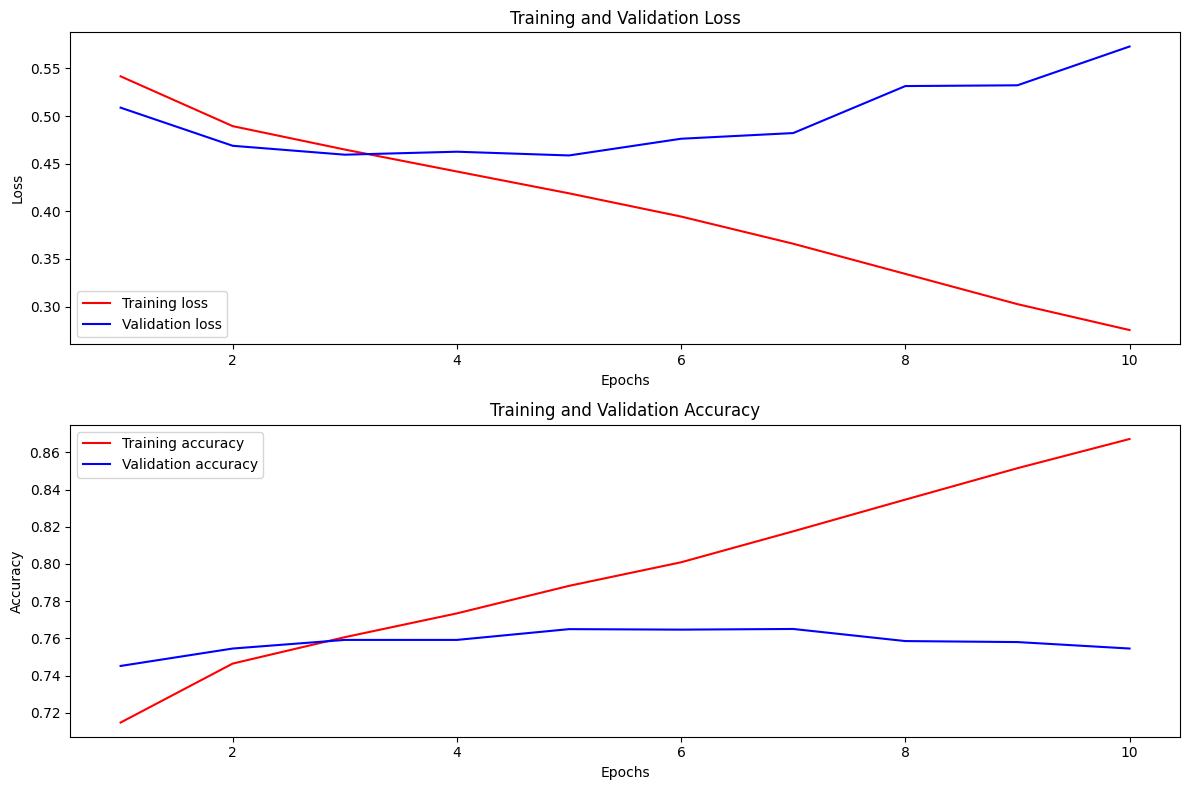

In [13]:
import matplotlib.pyplot as plt

# Retrieve values from the history object
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

# Create a figure with subplots
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(epochs, acc_values, "r", label="Training accuracy")
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [23]:
# Evaluate the model
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7667 - loss: 0.4578


In [21]:
from tensorflow.keras.regularizers import l2

# Define new, more complex model
def create_model_complex(input_shape):
    model = models.Sequential()
    
    # Input Layer with data augmentation
    model.add(layers.InputLayer(input_shape=input_shape))
    
    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    
    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    
    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    
    # Global Average Pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Create the model
model_complex = create_model_complex(input_shape=(N_MELS, X_train.shape[2], 1))

# Compile the model
model_complex.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_complex.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 40, 87, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 40, 87, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 40, 87, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 40, 87, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 43, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 20, 43, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 20, 43, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 10, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 10, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 355,809 (1.36 MB)

 Trainable params: 354,145 (1.35 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [22]:
# Fit the model
history_complex = model_complex.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
)

Epoch 1/20
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 257s 181ms/step - accuracy: 0.6441 - loss: 0.6962 - val_accuracy: 0.7185 - val_loss: 0.5212
Epoch 2/20
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 155s 110ms/step - accuracy: 0.7382 - loss: 0.5101 - val_accuracy: 0.7034 - val_loss: 0.5611
Epoch 3/20
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 175s 125ms/step - accuracy: 0.7492 - loss: 0.4865 - val_accuracy: 0.7309 - val_loss: 0.5026
Epoch 4/20
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 168s 120ms/step - accuracy: 0.7474 - loss: 0.4879 - val_accuracy: 0.7335 - val_loss: 0.4810
Epoch 5/20
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 167s 119ms/step - accuracy: 0.7579 - loss: 0.4788 - val_accuracy: 0.7401 - val_loss: 0.5106
Epoch 6/20
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 135s 96ms/step - accuracy: 0.7587 - loss: 0.4718 - val_accuracy: 0.7388 - val_loss: 0.5042
Epoch 7/20
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 252s 180ms/step - accuracy: 0.7636 - loss: 0.4638 - val_accuracy: 0.7696 - val_loss: 0.4564
Epoch 8/20
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 227s 162ms/step - acc

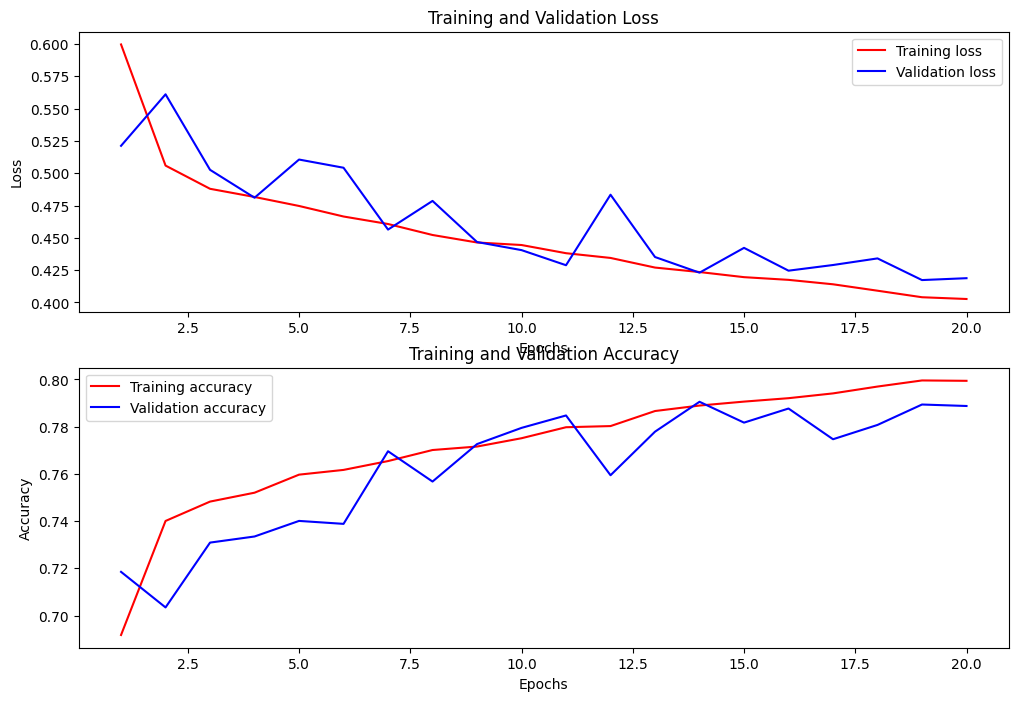

In [24]:
# Plot the training history
history_dict_complex = history_complex.history
loss_values_complex = history_dict_complex['loss']
val_loss_values_complex = history_dict_complex['val_loss']
acc_values_complex = history_dict_complex['accuracy']
val_acc_values_complex = history_dict_complex['val_accuracy']
epochs_complex = range(1, len(loss_values_complex) + 1)

# Create a figure with subplots
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(epochs_complex, loss_values_complex, "r", label="Training loss")
plt.plot(epochs_complex, val_loss_values_complex, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(epochs_complex, acc_values_complex, "r", label="Training accuracy")
plt.plot(epochs_complex, val_acc_values_complex, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [47]:
# Test the model
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
print(X_test.shape)
test_loss_complex, test_accuracy_complex = model_complex.evaluate(X_test, y_test)

(14024, 40, 87)
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7950 - loss: 0.4107


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Add channel dimension to X_test
X_test_new = np.expand_dims(X_test, axis=-1)  # Add a batch dimension if needed

# Make predictions
y_pred_complex = model_complex.predict(X_test_new)

# Convert predictions to binary (threshold at 0.5)
y_pred_complex_binary = (y_pred_complex > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_complex_binary, target_names=['Non-Cough', 'Cough']))

439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
              precision    recall  f1-score   support

   Non-Cough       0.78      0.69      0.73      5639
       Cough       0.80      0.87      0.83      8385

    accuracy                           0.79     14024
   macro avg       0.79      0.78      0.78     14024
weighted avg       0.79      0.79      0.79     14024



In [40]:
# Try to predict the label of the first test sample
# filename = os.path.join(COUGHVID_DIR, 'ffba4301-066a-4675-9548-34e7f5e758bf.wav') # cough
# filename = os.path.join(COUGHVID_DIR, 'ff8363d2-016d-4738-9499-4c62480886fb.wav') # cough
filename = 'sample1.wav' # cough
# filename = 'sample2.wav' # non-cough
# filename = os.path.join(COUGHVID_DIR, 'ff8300c7-fded-4ed0-b396-635f90d9b262.wav') # non-cough
# filename = os.path.join(COUGHVID_DIR, 'ff73ca29-4f61-42cf-9e3f-7e616da4cdde.wav') # non-cough continued by cough
# filename = os.path.join(non_cough_dir, 'fsd_1364.wav') # non-cough (applause sounds)


windows = split_audio(filename)

for window in windows:
    mfcc = extract_mfcc(window)
    mfcc_flat = mfcc.reshape(1, -1)
    mfcc_scaled = scaler.transform(mfcc_flat)
    mfcc_standard = mfcc_scaled.reshape(1, N_MELS, mfcc.shape[1], 1)
    prediction = model_complex.predict(mfcc_standard)
    print(f'Prediction: {prediction[0][0]}')

# Show the audio file
Audio(filename)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: 0.906857967376709
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: 0.9769353270530701
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: 0.9577740430831909
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: 0.9869900345802307
